In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import neurokit2 as nk

In [2]:
folder_path = r"D:/Dataset"
train = r'D:\OneDrive - Amrita Vishwa Vidyapeetham\Sem-6\Project\SP\train_dm.csv'
train_df = pd.read_csv(train)
train_df["path"] = train_df["path"].apply(lambda x: folder_path +"/"+ x)
train_df.head()

,file,label,path
0,daningram_15,dementia,D:/Dataset/dementia/Dan Ingram/daningram_15.wav
1,terryjones_5,dementia,D:/Dataset/dementia/Terry Jones/terryjones_5.wav
2,maureenforrester_5,dementia,D:/Dataset/dementia/Maureen Forrester/maureenf...
3,aileenhernandez_0,dementia,D:/Dataset/dementia/Aileen Hernandez/aileenher...
4,aileenhernandez_5_1,dementia,D:/Dataset/dementia/Aileen Hernandez/aileenher...


In [5]:
valid = r'D:\OneDrive - Amrita Vishwa Vidyapeetham\Sem-6\Project\SP\valid_dm.csv'
valid_df = pd.read_csv(valid)
valid_df["path"] = valid_df["path"].apply(lambda x: folder_path +"/"+ x)
valid_df.head()

,file,label,path
0,JimmyCalderwood_5,dementia,D:/Dataset/dementia/Jimmy Calderwood/JimmyCald...
1,vivnicholson_5,dementia,D:/Dataset/dementia/Viv Nicholson/vivnicholson...
2,IanHolm_2,dementia,D:/Dataset/dementia/Ian Holm/IanHolm_2.wav
3,CharmianCarr_15,dementia,D:/Dataset/dementia/Charmian Carr/CharmianCarr...
4,CharmianCarr_5,dementia,D:/Dataset/dementia/Charmian Carr/CharmianCarr...


In [3]:
#Check if all files are present
try:
    for path in train_df['path']:
        with open(path): pass
except FileNotFoundError:
    print("File not found")
    print(path)

In [7]:
#Check if all files are present
try:
    for path in valid_df['path']:
        with open(path): pass
except FileNotFoundError:
    print("File not found")
    print(path)

44100


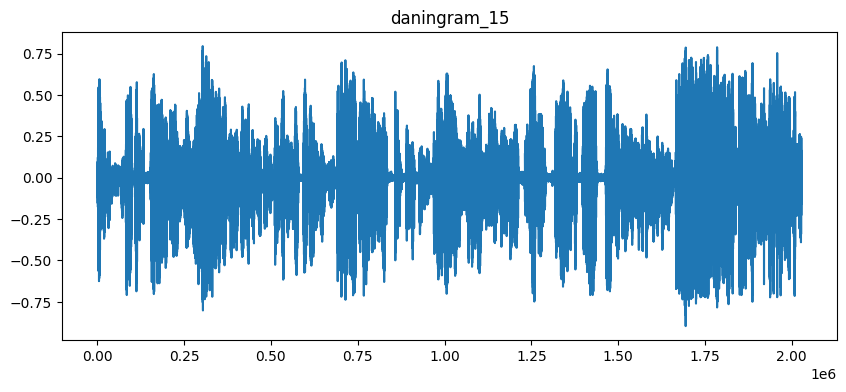

In [6]:
y, sr = librosa.load(train_df["path"][0], sr=None)
print(sr)
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title(train_df["file"][0])
plt.show()

In [4]:
# Function to divide signal into chunks
def split_signal(signal, sr, chunk_duration, overlap):
    """
    Splits an audio signal into overlapping chunks.

    Parameters:
      - signal (array): The raw audio signal.
      - sr (int): Sampling rate.
      - chunk_duration (float): Duration of each chunk in seconds.
      - overlap (float): Overlap fraction (0 to 1).

    Returns:
      - List of chunks (numpy arrays).
    """
    chunk_size = int(sr * chunk_duration)  # Convert seconds to samples
    step_size = int(chunk_size * (1 - overlap))  # Define step based on overlap
    chunks = [signal[i : i + chunk_size] for i in range(0, len(signal) - chunk_size + 1, step_size)]
    return chunks

In [9]:
def extract_features(file_path, target_sr= 16000 ,chunk_duration=0.05, overlap=0.05):
    """
    Loads an audio file at a reduced sampling rate, splits it into smaller chunks,
    extracts non-linear features (RQA and entropy) for each chunk, and then averages them.

    Parameters:
      - file_path (Path): Path to the audio file.
      - target_sr (int): Target sampling rate to reduce memory usage.
      - chunk_duration (float): Length (seconds) of each chunk.
      - overlap (float): Overlap fraction between chunks.

    Returns:
      - feature_dict (dict): Dictionary of averaged features.
    """
    try:
        # Load the audio at a lower sample rate to reduce memory usage.
        signal, sr = librosa.load(file_path, sr=target_sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    # Split the signal into smaller chunks
    chunks = split_signal(signal, sr, chunk_duration, overlap)
    if not chunks:
        return None

    rqa_features = []
    entropy_features = []

    # Process each chunk separately
    for chunk in chunks:
        try:
            # Unpack the tuple returned by complexity_rqa: (dataframe, info)
            rqa_results, _ = nk.complexity_rqa(chunk)
            # Convert the DataFrame to a dictionary
            rqa_dict = rqa_results.to_dict(orient="records")[0]
            rqa_features.append(list(rqa_dict.values()))

            # --- Extract Entropy Features ---
            sample_ent_raw = nk.entropy_sample(chunk)
            perm_ent_raw   = nk.entropy_permutation(chunk)

            # Extract numeric value from the returned tuple/list.
            sample_ent_value = sample_ent_raw[0] if isinstance(sample_ent_raw, (tuple, list)) and len(sample_ent_raw) > 0 else sample_ent_raw
            perm_ent_value   = perm_ent_raw[0]   if isinstance(perm_ent_raw, (tuple, list)) and len(perm_ent_raw) > 0 else perm_ent_raw

            entropy_features.append([sample_ent_value, perm_ent_value])
        except Exception as e:
            print(f"Error processing a chunk from {file_path}: {e}")
            continue

    if not rqa_features or not entropy_features:
        return None

    # Average the features across all chunks.
    rqa_mean = np.mean(rqa_features, axis=0)
    entropy_mean = np.mean(entropy_features, axis=0)

    feature_dict = {
        "sample_entropy": entropy_mean[0],
        "permutation_entropy": entropy_mean[1],
    }
    # Use the keys from the last processed chunk (assuming consistency)
    rqa_keys = list(rqa_dict.keys())
    for i, key in enumerate(rqa_keys):
        feature_dict[key] = rqa_mean[i]

    return feature_dict

In [8]:
train_df.head()

,file,label,path
0,daningram_15,dementia,D:/Dataset/dementia/Dan Ingram/daningram_15.wav
1,terryjones_5,dementia,D:/Dataset/dementia/Terry Jones/terryjones_5.wav
2,maureenforrester_5,dementia,D:/Dataset/dementia/Maureen Forrester/maureenf...
3,aileenhernandez_0,dementia,D:/Dataset/dementia/Aileen Hernandez/aileenher...
4,aileenhernandez_5_1,dementia,D:/Dataset/dementia/Aileen Hernandez/aileenher...


In [11]:
import pandas as pd
import os

features_list = []
csv_path = os.path.join(folder_path, "train_hurst_1.csv")

# Check if file exists to write headers only once
write_header = not os.path.exists(csv_path)

for idx, row in train_df.iterrows():
    file_path = row["path"]
    signal, _ = librosa.load(file_path, sr=16000)
    if signal is None:
        print(f"Error loading {file_path}")
        continue
    n = len(signal)
    print("Length of signal:", n)
    result = nk.fractal_hurst(signal, scale= [800,1600])
    print("Processed file:", row["file"])
    
    if result is not None:
        # Add metadata from the CSV
        fractal_exponent = result[0]
        result_info = result[1]
        values_array = result_info.get("Values", [])
        scores_array = result_info.get("Scores", [])
        intercept = result_info.get("Intercept", "")
        value_1 = values_array[0] if len(values_array) > 0 else ""
        value_2 = values_array[1] if len(values_array) > 1 else ""
        score_1 = scores_array[0] if len(scores_array) > 0 else ""
        score_2 = scores_array[1] if len(scores_array) > 1 else ""

        result_row = {
            "file": row["file"],
            "label": row["label"],
            "fractal_exponent": fractal_exponent,
            "value_1": value_1,
            "value_2": value_2,
            "score_1": score_1,
            "score_2": score_2,
            "intercept": intercept
        }
        features_list.append(result_row)

        # Convert to DataFrame for appending
        features_df = pd.DataFrame([result_row])

        # Append to CSV without overwriting previous rows
        features_df.to_csv(csv_path, mode='a', index=False, header=write_header)

        # Ensure headers are only written once
        write_header = False

Length of signal: 736000
Processed file: daningram_15
Length of signal: 704000
Processed file: terryjones_5
Length of signal: 928000
Processed file: maureenforrester_5
Length of signal: 752000
Processed file: aileenhernandez_0
Length of signal: 608000
Processed file: aileenhernandez_5_1
Length of signal: 1440000
Processed file: aileenhernandez_5_2
Length of signal: 1632015
Processed file: SteveLawrence_15
Length of signal: 1136188
Processed file: RayGalton_5
Length of signal: 608092
Processed file: BobbyWomack_0
Length of signal: 1440009
Processed file: PaulinePhillips_10
Length of signal: 1168000
Processed file: antonyflew_5_1
Length of signal: 1440000
Processed file: antonyflew_10
Length of signal: 416000
Processed file: antonyflew_5_2
Length of signal: 160000
Processed file: emilegriffith_5
Length of signal: 912000
Processed file: johnmackey_15_1
Length of signal: 176000
Processed file: johnmackey_15_2
Length of signal: 1440135
Processed file: DavidProwse_10
Length of signal: 912011

In [13]:
import pandas as pd
import os

features_list = []
csv_path = os.path.join(folder_path, "train_features.csv")

# Check if file exists to write headers only once
write_header = not os.path.exists(csv_path)

for idx, row in train_df.iterrows():
    file_path = row["path"]
    feats = extract_features(file_path)
    print("Processed file:", row["file"])
    
    if feats is not None:
        # Add metadata from the CSV
        feats["file"] = row["file"]
        feats["label"] = row["label"]
        features_list.append(feats)

        # Convert to DataFrame for appending
        features_df = pd.DataFrame([feats])

        # Append to CSV without overwriting previous rows
        features_df.to_csv(csv_path, mode='a', index=False, header=write_header)

        # Ensure headers are only written once
        write_header = False

Processed file: daningram_15
Processed file: terryjones_5
Processed file: maureenforrester_5
Processed file: aileenhernandez_0
Processed file: aileenhernandez_5_1
Processed file: aileenhernandez_5_2
Processed file: SteveLawrence_15
Processed file: RayGalton_5
Processed file: BobbyWomack_0
Processed file: PaulinePhillips_10
Processed file: antonyflew_5_1
Processed file: antonyflew_10
Processed file: antonyflew_5_2
Processed file: emilegriffith_5
Processed file: johnmackey_15_1
Processed file: johnmackey_15_2
Processed file: DavidProwse_10
Processed file: DavidProwse_5
Processed file: DavidProwse_0
Processed file: jimmclean_10
Processed file: AllanBurns_5
Processed file: OtisChandler_5
Processed file: PeterFalk_10
Processed file: PeterFalk_15
Processed file: mauricehinchey_5
Processed file: mauricehinchey_0_1
Processed file: mauricehinchey_0_2
Processed file: paulhornung_10
Processed file: paulhornung_0
Processed file: JamesStewart_5
Processed file: andrewsachs_15
Processed file: andrews

In [14]:
import pandas as pd
import os

features_list = []
csv_path = os.path.join(folder_path, "valid_features.csv")

# Check if file exists to write headers only once
write_header = not os.path.exists(csv_path)

for idx, row in valid_df.iterrows():
    file_path = row["path"]
    feats = extract_features(file_path)
    print("Processed file:", row["file"])
    
    if feats is not None:
        # Add metadata from the CSV
        feats["file"] = row["file"]
        feats["label"] = row["label"]
        features_list.append(feats)

        # Convert to DataFrame for appending
        features_df = pd.DataFrame([feats])

        # Append to CSV without overwriting previous rows
        features_df.to_csv(csv_path, mode='a', index=False, header=write_header)

        # Ensure headers are only written once
        write_header = False

Processed file: JimmyCalderwood_5
Processed file: vivnicholson_5
Processed file: IanHolm_2
Processed file: CharmianCarr_15
Processed file: CharmianCarr_5
Processed file: annettemichelson_15
Processed file: BillBuckner_5
Processed file: BillBuckner_10
Processed file: BillBuckner_15
Processed file: bbking_10
Processed file: bbking_15
Processed file: bbking_0
Processed file: JonathanMiller_5
Processed file: ErnieSigley_15
Processed file: JoeConley_0
Processed file: LeroneBennettJr_10
Processed file: JimmyFratianno_0
Processed file: CaseyKasem_5
Processed file: CaseyKasem_15
Processed file: EstelleGetty_15
Processed file: BillWyman_1
Processed file: BillWyman_3
Processed file: BillWyman_2
Processed file: Stan Lee_3
Processed file: Stan Lee_2
Processed file: Stan Lee_1
Processed file: Prince Philip_2
Processed file: Prince Philip_3
Processed file: Prince Philip_1
Processed file: GeorgeHWBush_3
Processed file: GeorgeHWBush_2
Processed file: Morgen Freeman_1
Processed file: Morgen Freeman_3
P

In [8]:
features_list = []

# Iterate over the DataFrame rows, extract features, and save with associated metadata.
for idx, row in train_df.iterrows():
    file_path = row["path"]
    feats = extract_features(file_path)
    print("Processed file:", row["file"])
    if feats is not None:
        # Add metadata from the CSV
        feats["file"] = row["file"]
        feats["label"] = row["label"]
        features_list.append(feats)

Processed file: daningram_15
Processed file: terryjones_5
Processed file: maureenforrester_5
Processed file: aileenhernandez_0
Processed file: aileenhernandez_5_1
Processed file: aileenhernandez_5_2
Processed file: SteveLawrence_15
Processed file: RayGalton_5
Processed file: BobbyWomack_0
Processed file: PaulinePhillips_10
Processed file: antonyflew_5_1
Processed file: antonyflew_10
Processed file: antonyflew_5_2
Processed file: emilegriffith_5
Processed file: johnmackey_15_1
Processed file: johnmackey_15_2
Processed file: DavidProwse_10
Processed file: DavidProwse_5
Processed file: DavidProwse_0
Processed file: jimmclean_10
Processed file: AllanBurns_5
Processed file: OtisChandler_5
Processed file: PeterFalk_10
Processed file: PeterFalk_15
Processed file: mauricehinchey_5
Processed file: mauricehinchey_0_1
Processed file: mauricehinchey_0_2
Processed file: paulhornung_10
Processed file: paulhornung_0
Processed file: JamesStewart_5
Processed file: andrewsachs_15
Processed file: andrews

In [9]:
# Create a new DataFrame with the extracted features.
features_df = pd.DataFrame(features_list)
print("Extracted features:")
print(features_df.head())

# Save the features DataFrame to a CSV file for further analysis or model training.
features_df.to_csv(folder_path + "/" + "train_features.csv", index=False)

Extracted features:
   sample_entropy  permutation_entropy  RecurrenceRate   DiagRec  Determinism  \
0        0.655904             0.910102        0.038267 -0.420971     0.737260   
1        0.486954             0.805802        0.051377 -0.338930     0.834892   
2        0.551652             0.881108        0.049039 -0.318985     0.794199   
3        0.389328             0.785541        0.086266 -0.464923     0.864325   
4        0.513410             0.877370        0.058842 -0.413050     0.807062   

     DeteRec         L  Divergence       LEn  Laminarity  TrappingTime  \
0  42.193980  4.445324    0.029074  1.647060    0.651897      4.950862   
1  30.434627  5.264745    0.013803  1.937988    0.781168      5.966292   
2  37.204205  4.751762    0.027193  1.858603    0.732787      5.462373   
3  24.200493  7.811962    0.015623  2.217183    0.800143     10.598027   
4  32.059198  8.086429    0.017387  1.905213    0.755932     10.826309   

         VMax       VEn           W         WMax

In [1]:
import os
import pandas as pd
import librosa
from tqdm import tqdm
import torch # PyTorch library
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib # For saving the LabelEncoder

# --- Configuration ---
INPUT_CSV = "D:/Dataset/Dementianet/data_files.csv"
folder_path = "D:/Dataset"
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-base-960h"
TARGET_SAMPLE_RATE = 16000
TRAINED_XGBOOST_OUTPUT_PATH = "trained_wav2vec_xgb_classifier.json"
LABEL_ENCODER_PATH = "label_encoder.joblib"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# --- Load Wav2Vec2 Model (Load once using PyTorch/Transformers) ---
print(f"Loading Wav2Vec2 Processor: {WAV2VEC2_MODEL_NAME}...")
processor = Wav2Vec2Processor.from_pretrained(WAV2VEC2_MODEL_NAME)
print(f"Loading Wav2Vec2 Model: {WAV2VEC2_MODEL_NAME}...")
wav2vec_model = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME) # This is a PyTorch model

# --- Determine device (GPU/CUDA if available, else CPU) ---
# This is the core CUDA detection logic using PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device) # Move the PyTorch model to the selected device (GPU or CPU)
wav2vec_model.eval() # Set PyTorch model to evaluation mode
print(f"Using device: {device}") # Check if it prints 'cuda' or 'cpu'


def extract_embeddings(input_csv, processor, wav2vec_model, device, target_sr):
    """
    Reads an input CSV, loads audio files, extracts Wav2Vec2 embeddings using PyTorch
    (potentially on CUDA device), and returns lists/arrays.
    """
    all_embeddings = []
    all_labels = []
    processed_filenames = []
    failed_files = []

    try:
        df = pd.read_csv(input_csv)
    except FileNotFoundError:
        print(f"Error: Input CSV file not found at '{input_csv}'.")
        return None, None, None, None
    except Exception as e:
        print(f"Error reading input CSV '{input_csv}': {e}.")
        return None, None, None, None

    print(f"Starting embedding extraction from {input_csv}...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Embeddings"):
        if not all(col in row for col in ["file", "label", "path"]):
            print(f"Warning: Skipping row {idx+2} in {input_csv} due to missing columns.")
            failed_files.append(f"Row {idx+2} (Missing Cols)")
            continue

        file_name = row["file"]
        label = row["label"]
        original_path = row["path"]
        audio_path = os.path.join(folder_path, original_path)

        if not os.path.exists(audio_path):
            print(f"Warning: File '{audio_path}' not found. Skipping.")
            failed_files.append(file_name)
            continue

        try:
            signal, sr = librosa.load(audio_path, sr=target_sr)
            if signal is None or len(signal) == 0:
                 print(f"Warning: Loaded empty signal for file '{audio_path}'. Skipping.")
                 failed_files.append(file_name)
                 continue

            # Preprocess for PyTorch model, requesting PyTorch tensors ("pt")
            input_values = processor(signal, sampling_rate=target_sr, return_tensors="pt", padding=True).input_values
            # Move input tensor to the selected device (GPU/CUDA or CPU)
            input_values = input_values.to(device)

            # Perform inference using PyTorch (on GPU if available)
            with torch.no_grad(): # PyTorch inference context
                outputs = wav2vec_model(input_values) # Runs on 'device'
                embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze() # PyTorch tensor operation

            # Store embedding (move back to CPU for NumPy conversion) and label
            all_embeddings.append(embedding.cpu().numpy())
            all_labels.append(label)
            processed_filenames.append(file_name)

        except Exception as e:
            print(f"Warning: Could not process file '{audio_path}': {e}")
            failed_files.append(file_name)
            continue

    print(f"Embedding extraction finished. Processed: {len(processed_filenames)}, Failed: {len(failed_files)}")
    if failed_files:
        print("Failed files/rows:", failed_files)

    if not all_embeddings:
        print("Error: No embeddings were successfully extracted.")
        return None, None, None, None

    embeddings_array = np.array(all_embeddings)
    labels_array = np.array(all_labels)

    return embeddings_array, labels_array, processed_filenames, failed_files


# --- Main Execution ---
if __name__ == "__main__":
    # 1. Extract Embeddings (uses PyTorch, automatically uses CUDA if available)
    embeddings, labels, filenames, failed = extract_embeddings(
        input_csv=INPUT_CSV,
        processor=processor,
        wav2vec_model=wav2vec_model, # This is the PyTorch model
        device=device,             # This is 'cuda' or 'cpu'
        target_sr=TARGET_SAMPLE_RATE
    )

    if embeddings is None or labels is None or len(embeddings) == 0:
        print("Exiting due to issues during embedding extraction.")
        exit()
    if len(embeddings) != len(labels):
         print(f"Mismatch between number of embeddings ({len(embeddings)}) and labels ({len(labels)}). Exiting.")
         exit()

    print(f"Successfully extracted {len(embeddings)} embeddings.")
    print("Shape of embeddings array:", embeddings.shape)

    # 2. Encode Labels (using scikit-learn)
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
    try:
        joblib.dump(label_encoder, LABEL_ENCODER_PATH)
        print(f"LabelEncoder saved to {LABEL_ENCODER_PATH}")
    except Exception as e:
        print(f"Warning: Could not save LabelEncoder: {e}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading Wav2Vec2 Processor: facebook/wav2vec2-base-960h...


c:\Users\swaro\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\swaro\anaconda3\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:54: FutureWarning: Loading a tokenizer inside Wav2Vec2Processor from a config that does not include a `tokenizer_class` attribute is deprecated and will be removed in v5. Please add `'tokenizer_class': 'Wav2Vec2CTCTokenizer'` attribute to either your `config.json` or `tokenizer_config.json` file to suppress this warning: 
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\swaro\\.cache\\huggingface\\hub\\models--facebook--wav2vec2-base-960h\\snapshots\\22aad52d435eb6dbaf354bdad9b0da84ce7d6156\\preprocessor_config.json'

In [ ]:
import numpy as np
import joblib

# Suppose these live in RAM right now:
# embeddings: np.ndarray of shape (N, D)
# labels:    np.ndarray or list of length N
# filenames: list of length N (optional)

# 1. Save embeddings (compressed)
np.savez_compressed("embeddings.npz", embeddings=embeddings)
print("→ embeddings.npz written")

# 2. Save labels
np.save("labels.npy", labels)
print("→ labels.npy written")

# 3. (Optional) Save filenames
joblib.dump(filenames, "filenames.joblib")
print("→ filenames.joblib written")